In [1]:
#from data_utils import *
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns


# Loading the data

This is the same data loading code from the EDA notebook.

We will load each disaster train dataset into a dictionary. Recall that each disaster consists of images and labels (0 - 3) of the damage level.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/data200cvproject"

 cv_eda_starter.ipynb
 cv_model_starter.ipynb
'Data 200 Final Report.gdoc'
 data_utils.py
 feature_utils.py
 home
'Milestone 2: EDA + Internal Peer Review (10%) - October 28, 2024.gdoc'
'Milestone 3: Mandatory Check-In (7.gdoc'
'Milestone 6: Peer Paper review by Jesse Maki Jeremy Millford Shawn Schulz.gdoc'
'old copy Data 200 Final Report (rough draft) due DEC 2nd.gdoc'
 __pycache__
 test_images_flooding-fire_predictions.csv
 test_images_hurricane-matthew_predictions2.csv
 test_images_hurricane-matthew_predictions.csv
'Untitled presentation.gslides'


In [5]:
import os
os.chdir("/content/drive/My Drive/data200cvproject")

In [6]:
from data_utils import get_images, get_labels

In [7]:
disaster_list = ["socal-fire", "midwest-flooding"]

In [8]:
data = {}
split = "train"
# with open('/content/EDA/config.json') as config_file:
#     config = json.load(config_file)
#     data_dir = "/content/EDA/config.json"

# Manually set the data directory, i don't think we need the config file for anything else?
data_dir = "./home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"

for disaster in disaster_list:
    print(f"Loading {split} images and labels for {disaster} dataset...")
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)
    data[disaster] = {"images": images, "labels": labels}

Loading train images and labels for socal-fire dataset...
Loading train images and labels for midwest-flooding dataset...


Let's visualize an image and its label in the dataset.

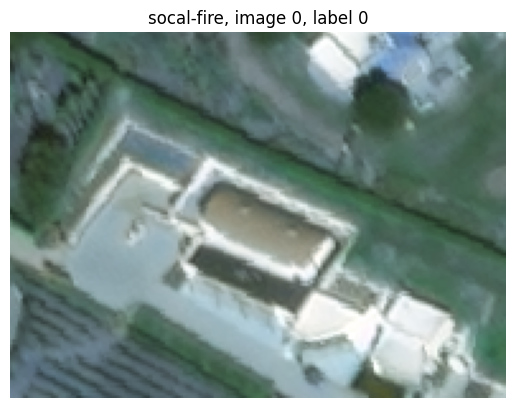

image shape: (144, 195, 3)


In [9]:
disaster = disaster_list[0]
images = data[disaster]["images"]
labels = data[disaster]["labels"]

# index of the image to display
idx = 0
img = images[idx]
label = labels[idx]

plt.title(f"{disaster}, image {idx}, label {label}")
plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.show()

#
print(f"image shape: {img.shape}")

### Plotting Functions

These functions aren't strictly necessary but will help visualize model training and performance on the final report

In [10]:
def plot_training_loss(loss, val_loss, title="Task 1 Training Loss", loss_type="Binary Cross Entropy"):
  x = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(x, loss, 'bo', label='Training loss')
  plt.plot(x, val_loss, 'b', label='Validation loss')
  plt.title(title)
  plt.xlabel("Training epoch")
  plt.ylabel(loss_type)
  plt.legend()
  plt.show()

def plot_training_accuracy(acc, val_acc, title="Task 1 Training Accuracy", accuracy_type="Accuracy"):
  x = range(1, len(acc) + 1)
  plt.figure()
  plt.plot(x, acc, 'bo', label='Training acc')
  plt.plot(x, val_acc, 'b', label='Validation acc')
  plt.title(title)
  plt.xlabel("Training epoch")
  plt.ylabel(accuracy_type)
  plt.legend()

def plot_training_f1(f1_score, val_f1 = None, title="Task 2 Training F1 Score"):
    x = range(1, len(f1_score) + 1)
    arr = pd.DataFrame(np.array([x.numpy() for x in f1_score]), columns = ["Level 0", "Level 1", "Level 2", "Level 3"])
    plt.figure()

    plt.plot(x, arr, label = arr.columns)
    if val_f1:
      plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title(title)
    plt.xlabel("Training epoch")
    plt.ylabel("F1 Score")
    plt.legend()

# Task A: Disaster Type Classification

Build a classifier that can distinguish images from the `midwest-flooding disaster` and the `socal-fire disaster`.

## Feature Engineering

Which features are useful for this classification task? Construct them here.

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Disaster types
disaster_list = ["socal-fire", "midwest-flooding"]
data = {}
split = "train"
data_dir = "./home/jovyan/shared/course/data100-shared-readwrite/fa24_grad_project_data/satellite-image-data"

# Target image shape
target_shape = (64, 64)

# Load and preprocess data
for disaster in disaster_list:
    images = get_images(data_dir, disaster, split=split)
    labels = get_labels(data_dir, disaster, split=split)

    # Resize images
    resized_images = [tf.image.resize(img, target_shape).numpy() for img in images]

    # Encode labels: floods = 0, fires = 1
    if disaster == "midwest-flooding":
        labels = np.zeros(len(labels), dtype=int)
    elif disaster == "socal-fire":
        labels = np.ones(len(labels), dtype=int)

    data[disaster] = {"images": np.array(resized_images), "labels": labels}

# Combine all data
all_images = np.concatenate([data[d]["images"] for d in disaster_list])
all_labels = np.concatenate([data[d]["labels"] for d in disaster_list])

# Clear memory
del data

# Normalize images
all_images = all_images.astype("float32") / 255.0

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Clear memory
del all_images, all_labels

## Model Training

Decide on an appropriate model and train it here. It may be necessary to compare between different types of models, and also tune hyperparameters later.

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential([
        # 1st conv block
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # 2nd conv block
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # Flatten and Dense layers
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# compile model
input_shape = X_train.shape[1:]
model = create_cnn_model(input_shape)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# dataset preparation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

# Train the model
epochs = 20
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

# Evaluate the model
val_loss, val_acc = model.evaluate(val_dataset, verbose=2)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.7604 - loss: 0.4935 - val_accuracy: 0.9152 - val_loss: 0.2422
Epoch 2/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 77s 109ms/step - accuracy: 0.9059 - loss: 0.2486 - val_accuracy: 0.9357 - val_loss: 0.1653
Epoch 3/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 83s 110ms/step - accuracy: 0.9444 - loss: 0.1544 - val_accuracy: 0.9620 - val_loss: 0.1127
Epoch 4/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 86s 121ms/step - accuracy: 0.9557 - loss: 0.1275 - val_accuracy: 0.9656 - val_loss: 0.0986
Epoch 5/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 77s 108ms/step - accuracy: 0.9661 - loss: 0.0969 - val_accuracy: 0.9678 - val_loss: 0.0898
Epoch 6/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 48s 124ms/step - accuracy: 0.9640 - loss: 0.0975 - val_accuracy: 0.9724 - val_loss: 0.0787
Epoch 7/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - accuracy: 0.9688 - loss: 0.0879 - val_accuracy: 0.9639 - val_loss: 0.1033
Epoch 8/20
385/385 ━━━━━━━━━━━━━━━━━━━━ 44s 115ms/step - accuracy: 0.9748 - loss: 0

In [13]:
#2nd try results about the same
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# def create_cnn_model(input_shape):
#     model = Sequential([
#         # 1st conv block
#         Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
#         MaxPooling2D((2, 2)),

#         # 2nd conv block
#         Conv2D(32, (3, 3), activation='relu', padding='same'),
#         MaxPooling2D((2, 2)),

#         # 3rd conv block
#         Conv2D(64, (3, 3), activation='relu', padding='same'),
#         MaxPooling2D((2, 2)),

#         # 4th conv block
#         Conv2D(128, (3, 3), activation='relu', padding='same'),
#         MaxPooling2D((2, 2)),

#         # Flatten and Dense layers
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(64, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='sigmoid')  # Binary classification
#     ])
#     return model

# # compile model
# input_shape = X_train.shape[1:]
# model = create_cnn_model(input_shape)
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # dataset preparation
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(32)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# # early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=3, restore_best_weights=True
# )

# # Train the model
# epochs = 20
# history = model.fit(
#     train_dataset,
#     epochs=epochs,
#     validation_data=val_dataset,
#     callbacks=[early_stopping]
# )

# # Evaluate the model
# val_loss, val_acc = model.evaluate(val_dataset, verbose=2)
# print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")


## Performance Assessment

Use the model to generate predictions for the `test_images_flooding-fire.npz` images. This should be in a csv file `test_images_flooding-fire_predictions.csv` consisting of a single column with no header, with a 0 to indicate a `midwest-flooding` prediction and a 1 to indicate a `socal-fire` prediction. The prediction in row *i* should correspond to the *ith* image.

In [14]:
from data_utils import load_images

In [15]:
!ls {data_dir}

hurricane-matthew  socal-fire			  test_images_hurricane-matthew.npz
midwest-flooding   test_images_flooding-fire.npz


In [16]:

# dataset for testing
test_im_flooding_fire_path = os.path.join(data_dir, "test_images_flooding-fire.npz")
test_im_flooding_fire = load_images(test_im_flooding_fire_path)

# preprocess test images (resize and normalize)
resized_test_images = [tf.image.resize(img, target_shape).numpy() for img in test_im_flooding_fire]
all_test_images = np.array(resized_test_images) / 255.0

#  predict
predictions = model.predict(all_test_images)

# convert to binary
pred_arr = (predictions > 0.5).astype(int).reshape(-1, 1)

# save predictions
ff_pred_df = pd.DataFrame(pred_arr, columns=['pred'])
ff_pred_df.to_csv("test_images_flooding-fire_predictions.csv", header=True, index=False)

print("Predictions saved to test_images_flooding-fire_predictions.csv")



121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step
Predictions saved to test_images_flooding-fire_predictions.csv


### Plots

In [17]:
# Grab the accuracy and loss from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

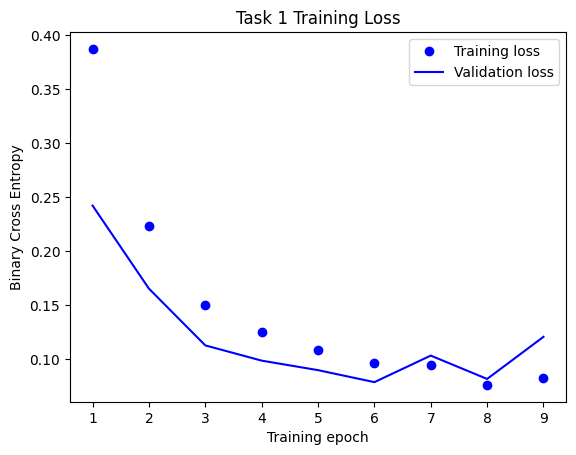

In [18]:
# Plot the loss
plot_training_loss(loss, val_loss)

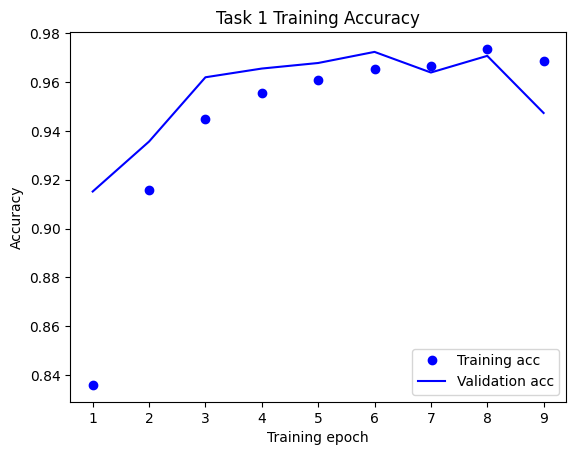

In [19]:
plot_training_accuracy(accuracy, val_accuracy)

# Task B: Damage Level Classification

Create a damage level classifier for the `hurricane-matthew` disaster.

## Feature Engineering

Which features are useful for this classification task? Construct them here.

In [20]:
labels_matt = get_labels(data_dir, "hurricane-matthew")
images_matt = get_images(data_dir, "hurricane-matthew")

In [21]:
# resize
target_shape = (64, 64)
resized_images_matt = [tf.image.resize(img, target_shape).numpy() for img in images_matt]

In [22]:
# normalize pixel intensities
all_images_matt = np.array(resized_images_matt) / 255

In [23]:
all_labels_matt = tf.keras.utils.to_categorical(labels_matt,4)

## Model Training

Decide on an appropriate model and train it here. It may be necessary to compare between different types of models, and also tune hyperparameters later.

In [24]:
X_train.shape

(12307, 64, 64, 3)

In [25]:
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.9 MB/s eta 0:00:00


In [26]:
%pdb on

Automatic pdb calling has been turned ON


In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.optimizers import Adam

X_train, X_val, y_train, y_val = train_test_split(all_images_matt, all_labels_matt, test_size=0.2, random_state=42)

# deleting all_images and all_labels due to memory constrains
#del all_images_matt, labels_matt

input_shape = X_train.shape[1:]
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Input(shape = input_shape),
        Conv2D(8, (3, 3), strides = 2, activation='relu', padding='same'),
        Conv2D(16, (3, 3), strides = 2, activation='relu', padding='same'),
        Conv2D(32, (3, 3), strides = 2, activation='relu', padding='same'),
        Conv2D(64, (3, 3), strides = 2, activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(36, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

matt_model = create_cnn_model(input_shape, 4)
matt_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['F1Score'])

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)

epochs = 30
history = matt_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

val_loss, val_acc = matt_model.evaluate(val_dataset, verbose=2)

Epoch 1/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - F1Score: 0.1666 - loss: 1.2801 - val_F1Score: 0.1596 - val_loss: 1.2684
Epoch 2/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - F1Score: 0.1601 - loss: 1.2567 - val_F1Score: 0.2124 - val_loss: 1.2284
Epoch 3/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - F1Score: 0.2543 - loss: 1.2139 - val_F1Score: 0.2453 - val_loss: 1.2579
Epoch 4/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - F1Score: 0.2698 - loss: 1.1742 - val_F1Score: 0.3268 - val_loss: 1.1448
Epoch 5/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - F1Score: 0.3531 - loss: 1.1269 - val_F1Score: 0.3656 - val_loss: 1.1109
Epoch 6/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - F1Score: 0.3788 - loss: 1.1029 - val_F1Score: 0.3732 - val_loss: 1.1062
Epoch 7/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - F1Score: 0.3971 - loss: 1.0818 - val_F1Score: 0.3763 - val_loss: 1.0897
Epoch 8/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - F1Score: 0.3945 - loss: 1.0751 - val_F1Score: 0.3844

## Performance Assessment

Use the model to generate predictions for the `test_images_hurricane-matthew.npz` images. This should be in a CSV file `test_images_hurricane-matthew_predictions.csv` consisting of a single column with no header, with a 0-3 prediction of the damage level. The prediction in row *i* should correspond to the *i*th image.

In [28]:
import os
import pandas as pd

# Load the test dataset using the specified function
test_im_hurricane_path = os.path.join(data_dir, "test_images_hurricane-matthew.npz")
test_im_hurricane = load_images(test_im_hurricane_path)

# Preprocess the test images (resize and normalize)
resized_test_images = [tf.image.resize(img, target_shape).numpy() for img in test_im_hurricane]
all_test_images = np.array(resized_test_images) / 255.0

# Predict on the test images
predictions = matt_model.predict(all_test_images)
pred_arr = np.argmax(predictions, axis=1).reshape(-1, 1)  # Convert probabilities to class labels

# Save predictions to CSV
matt_pred_df = pd.DataFrame(pred_arr[:, 0], columns=['pred'])
matt_pred_df.to_csv("test_images_hurricane-matthew_predictions.csv", header=True, index=False)

print("Predictions saved to test_images_hurricane-matthew_predictions.csv")

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Predictions saved to test_images_hurricane-matthew_predictions.csv


### Plotting

In [29]:
# Grab the accuracy and loss from the history
f1_score = history.history['F1Score']
loss = history.history['loss']
val_loss = history.history['val_loss']

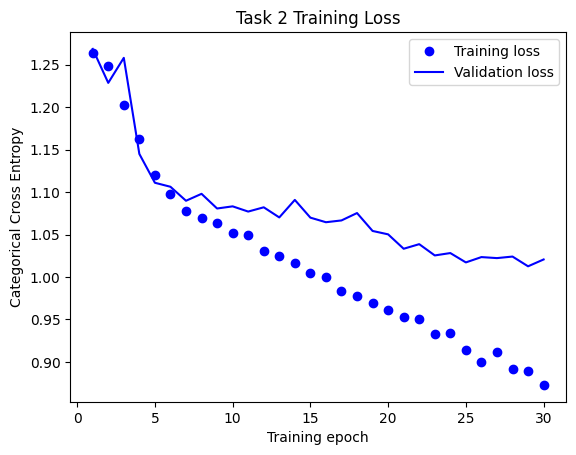

In [30]:
plot_training_loss(loss, val_loss, title= "Task 2 Training Loss", loss_type="Categorical Cross Entropy")

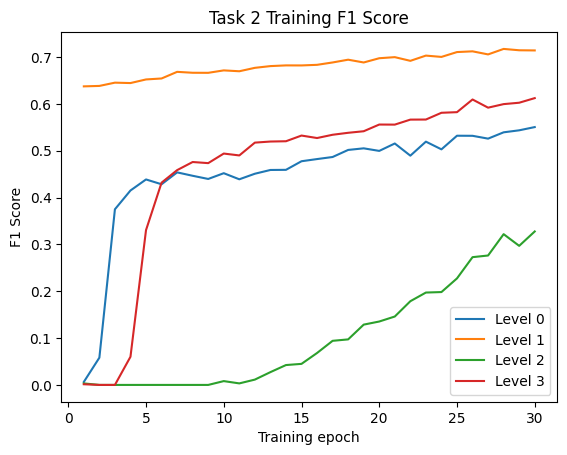

In [31]:
plot_training_f1(f1_score, title = "Task 2 Training F1 Score")

###trying other code

In [32]:
# Load images and labels
labels_matt = get_labels(data_dir, "hurricane-matthew")
images_matt = get_images(data_dir, "hurricane-matthew")


In [33]:
import numpy as np
import tensorflow as tf

# Resize images
target_shape = (64, 64)
resized_images_matt = [tf.image.resize(img, target_shape).numpy() for img in images_matt]

# Normalize images
all_images_matt = np.array(resized_images_matt) / 255.0

# One-hot encode labels (assuming 4 classes: 0, 1, 2, 3)
all_labels_matt = tf.keras.utils.to_categorical(labels_matt, num_classes=4)


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    all_images_matt, all_labels_matt, test_size=0.2, random_state=42
)


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model
def create_model(input_shape=(64, 64, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model
model = create_model()

# Summary of the model
model.summary()

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 683,716 (2.61 MB)

 Trainable params: 683,716 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 75s 260ms/step - accuracy: 0.4645 - loss: 1.2852 - val_accuracy: 0.4688 - val_loss: 1.2714
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 85s 271ms/step - accuracy: 0.4778 - loss: 1.2572 - val_accuracy: 0.4747 - val_loss: 1.2392
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 71s 256ms/step - accuracy: 0.4781 - loss: 1.2361 - val_accuracy: 0.4810 - val_loss: 1.2061
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 88s 277ms/step - accuracy: 0.4878 - loss: 1.1984 - val_accuracy: 0.4859 - val_loss: 1.1661
Epoch 5/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 77s 261ms/step - accuracy: 0.5002 - loss: 1.1574 - val_accuracy: 0.5150 - val_loss: 1.1676
Epoch 6/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 68s 242ms/step - accuracy: 0.5254 - loss: 1.1266 - val_accuracy: 0.5303 - val_loss: 1.1078
Epoch 7/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 68s 244ms/step - accuracy: 0.5275 - loss: 1.1098 - val_accuracy: 0.5446 - val_loss: 1.0803
Epoch 8/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 71s 255ms/step - accuracy: 0.5393 -

In [36]:
import os
import pandas as pd

# Load the test dataset using the specified function
test_im_hurricane_path = os.path.join(data_dir, "test_images_hurricane-matthew.npz")
test_im_hurricane = load_images(test_im_hurricane_path)

# Preprocess the test images (resize and normalize)
resized_test_images = [tf.image.resize(img, target_shape).numpy() for img in test_im_hurricane]
all_test_images = np.array(resized_test_images) / 255.0

# Predict on the test images
predictions = model.predict(all_test_images)
pred_arr = np.argmax(predictions, axis=1).reshape(-1, 1)  # Convert probabilities to class labels

# Save predictions to CSV
matt_pred_df = pd.DataFrame(pred_arr[:, 0], columns=['pred'])
matt_pred_df.to_csv("test_images_hurricane-matthew_predictions.csv", header=True, index=False)

print("Predictions saved to test_images_hurricane-matthew_predictions.csv")


88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step
Predictions saved to test_images_hurricane-matthew_predictions.csv


In [37]:
output_path = os.path.abspath("test_images_hurricane-matthew_predictions.csv")
print(f"Predictions saved to: {output_path}")


Predictions saved to: /content/drive/.shortcut-targets-by-id/1zzIas5QOuK2L3t0-BSThlNodD-ZVeBGO/data200cvproject/test_images_hurricane-matthew_predictions.csv


In [38]:
import os
print(f"Current working directory: {os.getcwd()}")


Current working directory: /content/drive/.shortcut-targets-by-id/1zzIas5QOuK2L3t0-BSThlNodD-ZVeBGO/data200cvproject
